In [622]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from operator import itemgetter
import graphviz

In [623]:
data = pd.read_csv('car_data.csv')
data.head()

,User ID,Gender,Age,AnnualSalary,Purchased
0,385,Male,35,20000,0
1,681,Male,40,43500,0
2,353,Male,49,74000,0
3,895,Male,40,107500,1
4,661,Male,25,79000,0


In [624]:
le = LabelEncoder()
mms = MinMaxScaler()
data['Age'] = mms.fit_transform(data[['Age']])
data['AnnualSalary'] = mms.fit_transform(data[['AnnualSalary']])
data['Gender'] = le.fit_transform(data['Gender'])
data = data.drop(columns=['User ID'])
data.head()

,Gender,Age,AnnualSalary,Purchased
0,1,0.377778,0.036364,0
1,1,0.488889,0.207273,0
2,1,0.688889,0.429091,0
3,1,0.488889,0.672727,1
4,1,0.155556,0.465455,0


In [625]:
TARGET_KEY = 'Purchased'
X_data, y_data = data.drop(columns=[TARGET_KEY]), data[[TARGET_KEY]]
X_test, X_train, y_test, y_train = train_test_split(X_data, y_data)

In [626]:
def class_accuracy_score(y_true: pd.DataFrame, y_pred: np.ndarray):
    unique, counts = np.unique(y_true[TARGET_KEY], return_counts=True)
    y_true_values = y_true[TARGET_KEY].values
    result = {}
    for value in unique:
        result[value] = 0
    for index in range(len(y_true_values)):
        if y_true_values[index] == y_pred[index]:
            result[y_true_values[index]] += 1
    for index in range(len(unique)):
        result[unique[index]] /= counts[index]
    result['all'] = accuracy_score(y_true, y_pred)
    return result

In [627]:
lr = LogisticRegression(random_state=0)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

/home/pahan/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [628]:
svm = SVC(kernel='linear', random_state=0)
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)

/home/pahan/.local/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [629]:
dt = DecisionTreeClassifier(random_state=0)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [630]:
lr_accuracy_scores = class_accuracy_score(y_test, y_pred_lr)
pd.DataFrame.from_dict(lr_accuracy_scores, orient='index', columns=['accuracy'])

,accuracy
0,0.902004
1,0.700997
all,0.821333


In [631]:
svm_accuracy_scores = class_accuracy_score(y_test, y_pred_svm)
pd.DataFrame.from_dict(svm_accuracy_scores, orient='index', columns=['accuracy'])

,accuracy
0,0.906459
1,0.681063
all,0.816000


In [632]:
dt_accuracy_scores = class_accuracy_score(y_test, y_pred_dt)
pd.DataFrame.from_dict(dt_accuracy_scores, orient='index', columns=['accuracy'])

,accuracy
0,0.855234
1,0.850498
all,0.853333


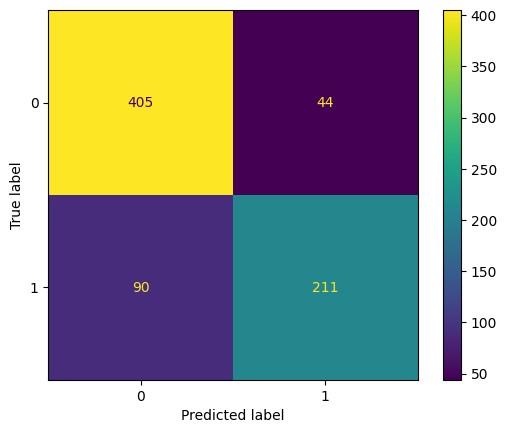

In [633]:
lr_confusion_matrix = confusion_matrix(y_test, y_pred_lr)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr)

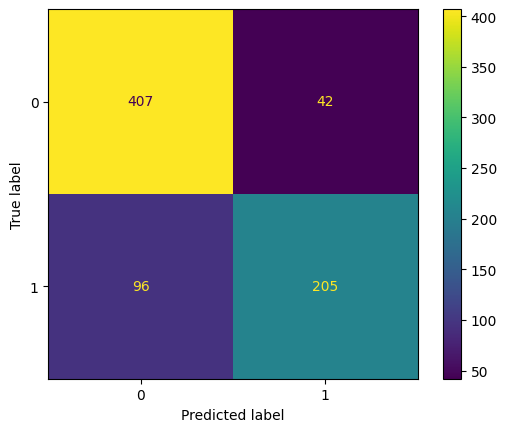

In [634]:
svm_confusion_matrix = confusion_matrix(y_test, y_pred_svm)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svm)

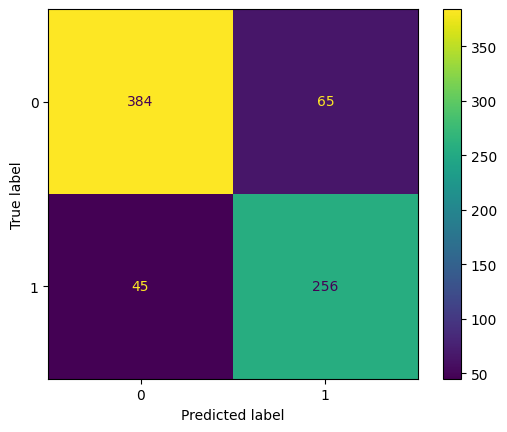

In [635]:
dt_confusion_matrix = confusion_matrix(y_test, y_pred_dt)
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_dt)

In [636]:
def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

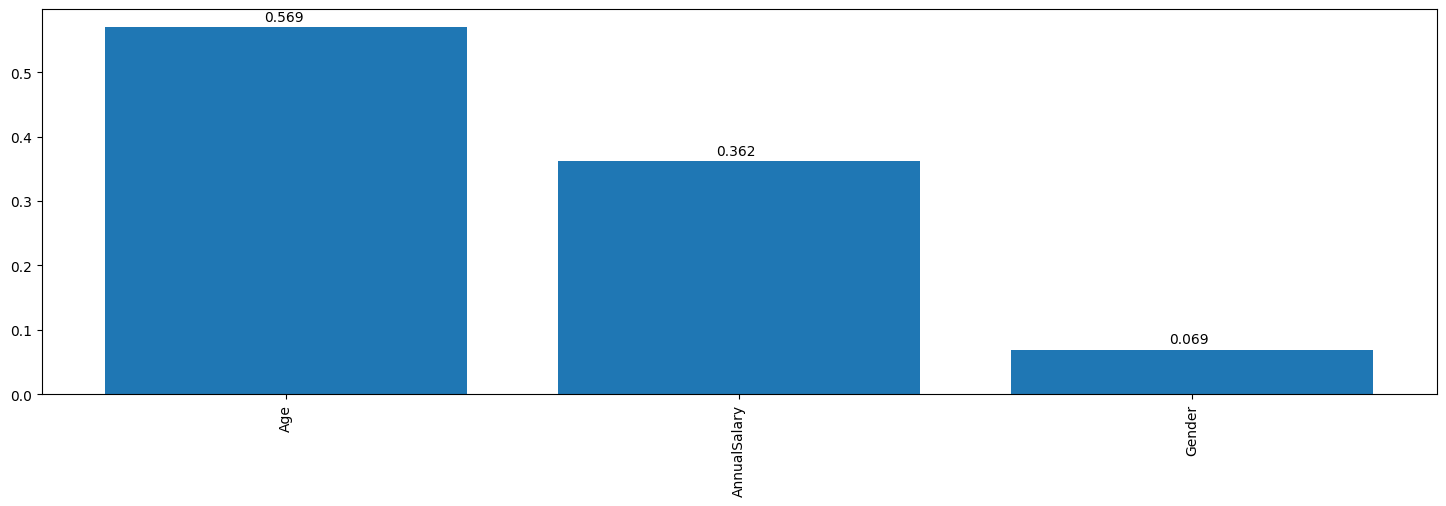

(['Age', 'AnnualSalary', 'Gender'],
 [0.5694696951624197, 0.3616266023867982, 0.068903702450782])

In [637]:
draw_feature_importances(dt, X_test)

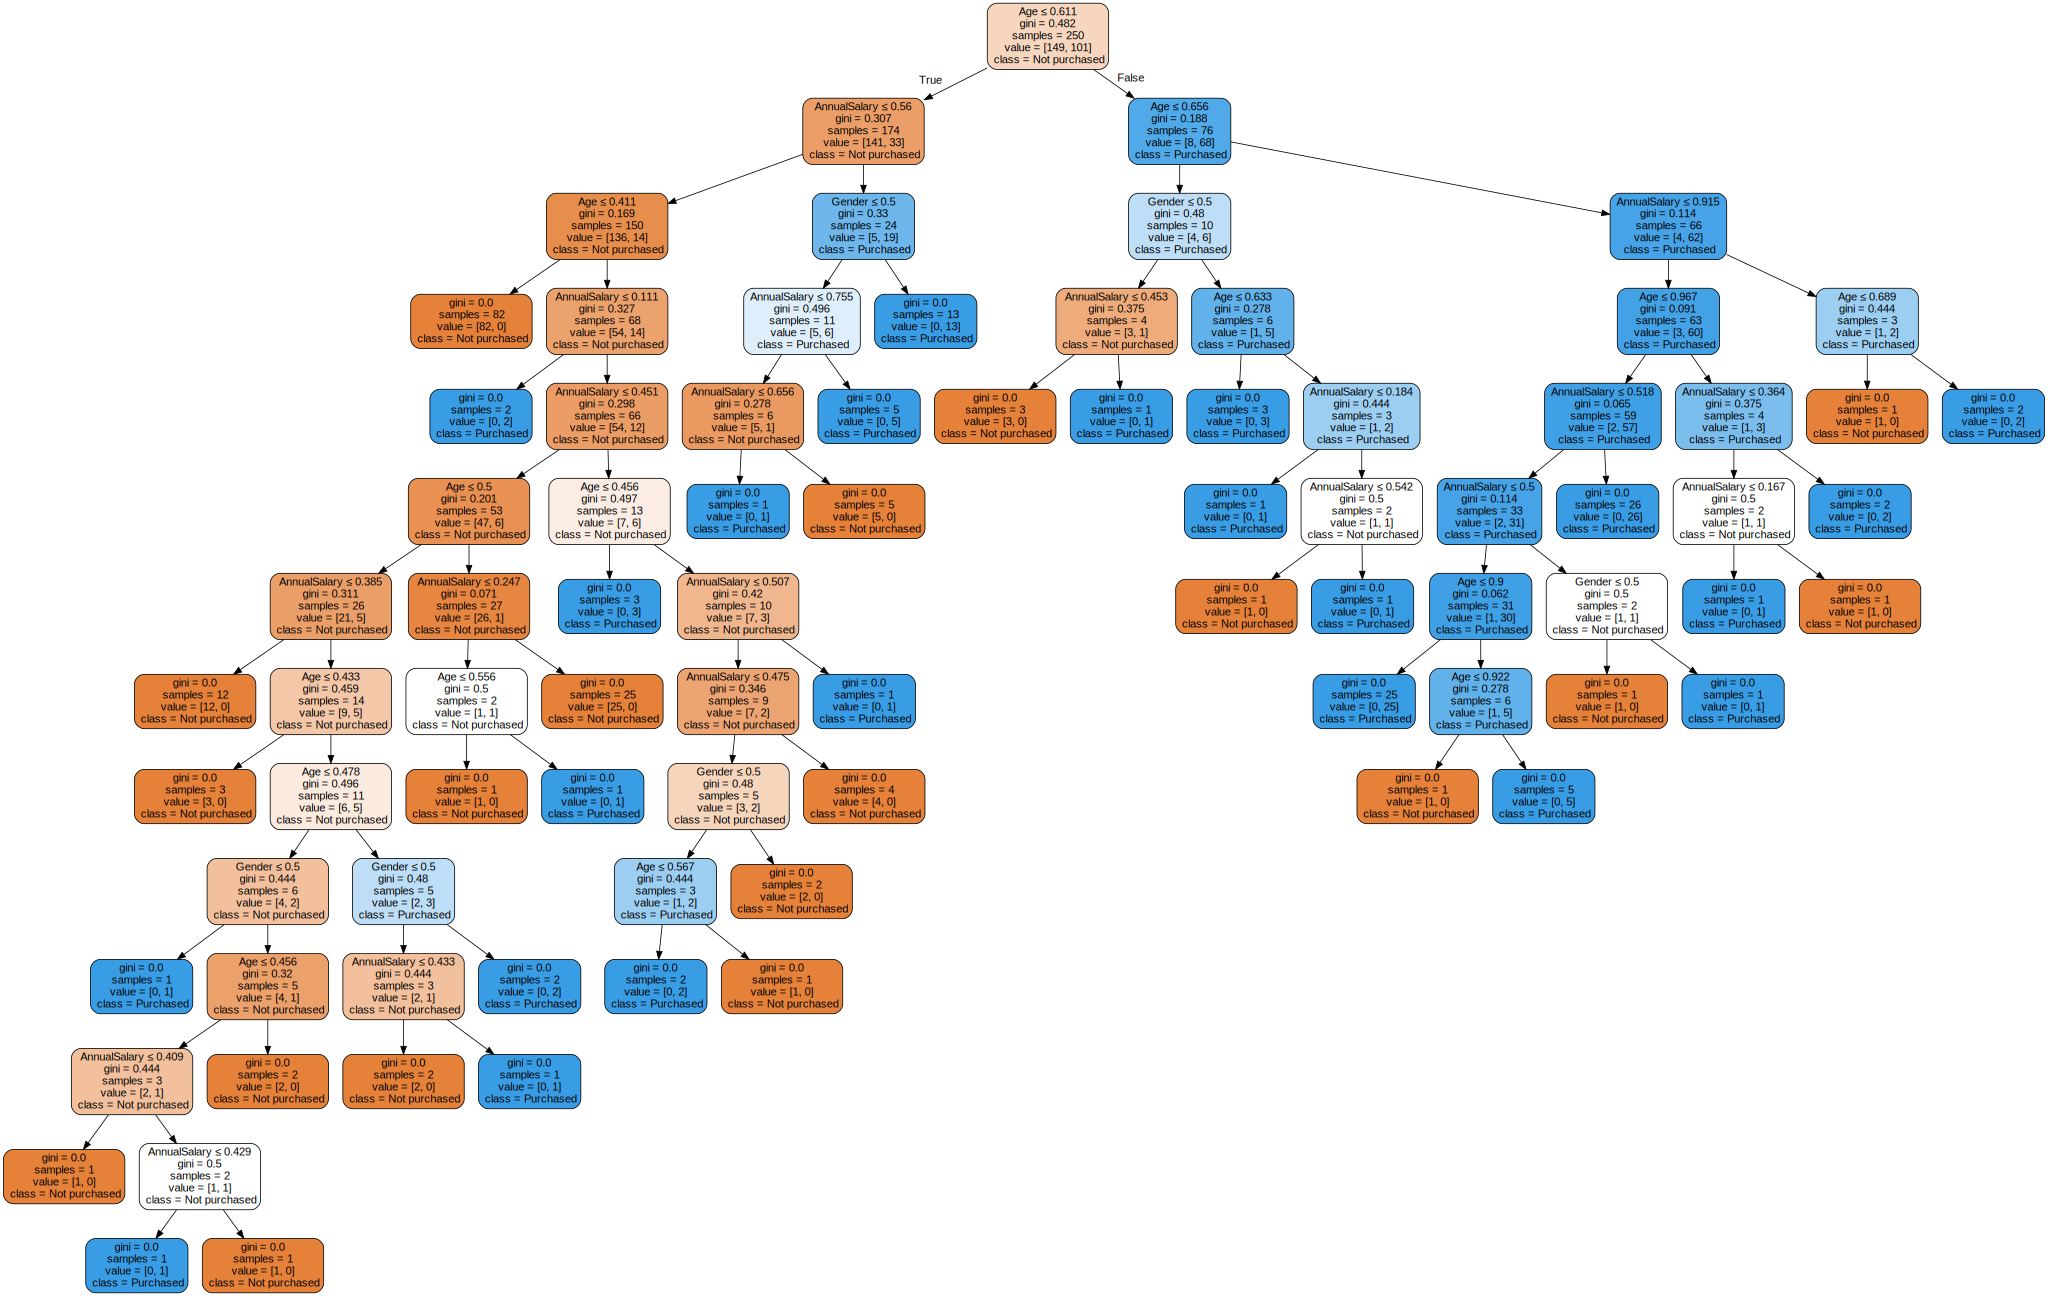

In [638]:
graph_data = export_graphviz(dt, out_file=None, feature_names=X_test.columns, class_names=['Not purchased', 'Purchased'], filled=True, rounded=True, special_characters=True)
graph = graphviz.Source(graph_data)
graph